# Mask R-CNN Species Photogrammetry

### Environment Setup

In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import imgaug
from imgaug import augmenters as iaa
import numpy.ma as ma
import scipy.misc
import skimage.filters

# Root directory of the project
MASK_RCNN_DIR = os.path.abspath("../Mask_RCNN/")
ROOT_DIR = os.path.abspath(".")

# Import Mask RCNN
sys.path.append(MASK_RCNN_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

import whale

%matplotlib inline 

# Directory to save logs and trained model
#MODEL_DIR = os.path.join(ROOT_DIR, "logs")
MODEL_DIR = os.path.abspath("../Mask_RCNN/logs/")


Using TensorFlow backend.


### Model and dataset setup

In [2]:
config = whale.WhaleConfig()
WHALE_DIR = os.path.abspath("../photogram_data/")

# Override the training configurations with a few
# changes for inferencing.
class InferenceConfig(config.__class__):
# Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
#config.display()

# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/cpu:0" # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# TODO: code for 'training' test mode not ready yet
TEST_MODE = "inference"




In [7]:
# Load dataset to measure
dataset = whale.WhaleDataset()
dataset.load_whale(WHALE_DIR, "test")
#dataset.load_whale(WHALE_DIR, "test")

# Must call before using the dataset
dataset.prepare()
print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

Images: 60
Classes: ['BG', 'balaenoptera_musculus_body', 'balaenoptera_musculus_pectoral', 'megaptera_novaeangliae_body', 'megaptera_novaeangliae_pectoral', 'balaenoptera_acutorostrata_body', 'balaenoptera_acutorostrata_pectoral']


In [8]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [9]:
# Create model in inference mode
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR,
                          config=config)

## Function Definitions

In [10]:
def run_cnn(weights_path="/home/clifgray/Code/Mask_RCNN/logs/whale20180613T0247/mask_rcnn_whale_0150.h5", verbose=0):
        
    # Load weights
    #weights_path = model.find_last()[1]
    print("Loading weights ", weights_path)
    model.load_weights(weights_path, by_name=True)
    print("Weights loaded.")
    
    
    detection_results = []
    initial_time = time.perf_counter()
    for image_id in dataset.image_ids:
    
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)

        info = dataset.image_info[image_id]

        # Run object detection
        results = model.detect([image], verbose=0)
        
        #detection_results.append([results, info, image_id])
        detection_results.append([results, info['id'], image_id, {'class_ids' : gt_class_id, 'masks' : gt_mask}])
        if verbose:
            print("Done detecting and masking image #:  " + str(len(detection_results)))
    
    finish_time = time.perf_counter()
    time_elapsed = finish_time - initial_time
    if verbose:
        print("\n")
        print(time_elapsed, "seconds elapsed while masking", len(detection_results), "images.")
        print((time_elapsed/len(detection_results), "seconds per image."))
    
    return detection_results



In [11]:
def pca(body, visualize=False):
    xy_array = []
    # get indexes of mask pixels
    y, x = np.nonzero(body)
    
    # mean center the coords
    x = x - np.mean(x)
    y = y - np.mean(y)
    coords = np.vstack([x, y])

    # build covariance matreix and eigenvectors
    cov = np.cov(coords)
    evals, evecs = np.linalg.eig(cov)
    
    # sort eigenvalues
    sort_indices = np.argsort(evals)[::-1]
    x_v1, y_v1 = evecs[:, sort_indices[0]]  # Eigenvector with largest eigenvalue
    x_v2, y_v2 = evecs[:, sort_indices[1]]

    
    if visualize is True:
        # plot the major and minor axis of the whale mask
        scale = 20
        plt.plot(x, y, 'k.')

        plt.plot([x_v1*-scale*2, x_v1*scale*2],
         [y_v1*-scale*2, y_v1*scale*2], color='red')
        plt.plot([x_v2*-scale, x_v2*scale],
         [y_v2*-scale, y_v2*scale], color='blue')
        plt.axis('equal')
        plt.gca().invert_yaxis()  # Match the image system with origin at top left
        plt.show()

    # orient this along the horizontal axis
    theta = np.tanh((x_v2)/(y_v2))  
    rotation_mat = np.matrix([[np.cos(theta), -np.sin(theta)],
                      [np.sin(theta), np.cos(theta)]])
    transformed_mat = rotation_mat * coords
    
    # plot the transformed blob
    # these are the final transformed coords
    x_transformed, y_transformed = transformed_mat.A

    maxX = np.max(x_transformed)
    minX = np.min(x_transformed)
    maxY = np.max(y_transformed)
    minY = np.min(y_transformed)


    # Get corresonding Y values for minX and maxX
    maxX_index = np.where(x_transformed == maxX)  # index of right-most point
    rightY = float((y_transformed[maxX_index]))   # corresponding Y value


    minX_index = np.where(x_transformed == minX)  # index of left-most point
    leftY = float((y_transformed[minX_index]))    # corresponding Y value
    
    # Orient the mask correctly - flip so the fluke is on the right

    # Get corresonding X values for maxY and minY

    maxY_index = np.where(y_transformed == maxY) #index of top point
    topX = float((x_transformed[maxY_index])) #corresponding X value


    minY_index = np.where(y_transformed == minY) #index of bottom point
    bottomX = float((x_transformed[minY_index])) #corresponding X value

    # flip mask so fluke is on the right, if necessary
    if (topX < 0 or bottomX < 0):
        x_transformed = x_transformed*-1 
    
    xy_array = [x_transformed, y_transformed]
    
    
    return xy_array


In [12]:
def measure(body_mask, visualize=False):
    xy_array = pca(body_mask. visualize=visualize)
    x_transformed = xy_array[0]
    y_transformed = xy_array[1]

    # Reassign max/min X values in case image was flipped during PCA
    maxX = np.max(x_transformed) # Right-most point
    minX = np.min(x_transformed) # Left-most point

    # Get corresponding Y values for maxX and minX
    maxX_index = np.where(x_transformed == maxX)  # index of right-most point
    rightY = float((y_transformed[maxX_index]))   # corresponding Y value

    minX_index = np.where(x_transformed == minX)  # index of left-most point
    leftY = float((y_transformed[minX_index]))    # corresponding Y value

    # TODO come up with a better solution here

    # Draw a straight line across the mask

    # Filter out points close to the midline of the mask (on the Y axis)
    # TODO arbitrary lambda, might need to change later
    lowEnough = list(filter(lambda y: y < (leftY + 0.5), y_transformed)) #above midline
    yValues = list(filter(lambda y: y > (leftY - 0.5), lowEnough)) #below midline
    yValues.sort()

    # Get corresponding X values to draw the line

    # List of appropriate indices
    indices = []
    for point in yValues:
        index = int(np.where(y_transformed == point)[0])
        indices.append(index)

    xValues = [] # Corresponding X values
    for index in indices:
        xValues.append(x_transformed[index]) 

    xValues.sort()

    # Use distance formula to measure the length from the midline
    length = math.sqrt((xValues[-1] - xValues[0])**2 + (yValues[-1] - yValues[0])**2)
    
    return(length)
        

In [13]:
# Each image could have multiple masks (body and pectoral) and multiple animals
# Return all of the body masks

def find_correct_masks(mask_list): 
    class_body_array = []
    for index, class_id in enumerate(mask_list['class_ids']):
        if class_id % 2 != 0: # all body class ids are odd numbers
            class_body_array.append([class_id, mask_list['masks'][:,:,index]])    
    return(class_body_array)

In [14]:
def append_measurements(results_list, manual=False):
    """
    this changes detections results from:
        [results, info['id'], image_id, gt_mask_dict]
    to:
        [results, info['id'], image_id, gt_mask_dict, 
          [class_id, cnn_lengths], [class_id, gt_lengths]]

    """
    #image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    #    modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
    # TODO why is this loaded???
        
    for detection_result in results_list:
        detected_mask_list = detection_result[0][0]
        gt_mask_list = detection_result[3]
            
        detected_body_list = find_correct_masks(detected_mask_list)  
        gt_body_list = find_correct_masks(gt_mask_list)

        detected_body_lengths = []
        for class_id_body in detected_body_list:
            detected_body_lengths.append([class_id_body[0], measure(class_id_body[1])])
        
        gt_body_lengths = []
        for class_id_body in gt_body_list:
            gt_body_lengths.append([class_id_body[0], measure(class_id_body[1])])
       
        detection_result.append(detected_body_lengths)
        detection_result.append(gt_body_lengths)
        # detection_results is now [results, info['id'], image_id, gt_mask_dict, [class_id, cnn_lengths], [class_id, gt_lengths]]
            
    return(True)
    

In [15]:
def girth(results_list, length_list, num_of_increments, manual=False, visualize=False):
    
    girth_measurements = []

    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
    
    for item in results_list: # get the mask and length
        if not manual:
            mask = item[0][0]["masks"]
            length = item[3]
            img_id = item[2]
        else:
            mask = item
            index = results_list.index(item)
            length = length_list[index]
            img_id = index
            
        body = find_correct_masks(mask) # ignore pectoral masks
        increment = length / num_of_increments
        
        xy_array = pca(body)
        x_transformed = xy_array[0]
        y_transformed = xy_array[1]
        
        #print("Increment in Pixels", increment)
        
        maxX = np.max(x_transformed)
        minX = np.min(x_transformed)
        maxY = np.max(y_transformed)
        minY = np.min(y_transformed)
        
        plt.plot(x_transformed, y_transformed, 'g.', zorder=0)
        
        avgY = (sum(y_transformed) / len(y_transformed))
        currentX = minX
        
        current_whale_girth = []
        while(currentX < maxX-increment): 
            plt.scatter(currentX, avgY)
            
            
            # At each X, filter out Y values from y_transformed to get vertical line
                # Similar to measure()
            # Filter out points close to vertical line 

            right_x_values = list(filter(lambda x: x < (currentX + 0.5), x_transformed))
            xValues = list(filter(lambda x: x > (currentX - 0.5), right_x_values)) 
            xValues.sort()

            # Get corresponding Y values to find top and bottom of line
            # List of appropriate indices
            indices = []
            for point in xValues:
                index = int(np.where(x_transformed == point)[0])
                indices.append(index)
    
            yValues = [] # Corresponding X values
            for index in indices:
                yValues.append(y_transformed[index]) 

            yValues.sort()
            plt.scatter(xValues, yValues, zorder=10)
            
            # Measuring girth as an array output (tuple)
            girth = math.sqrt((xValues[-1] - xValues[0])**2 + (yValues[-1] - yValues[0])**2)
            current_whale_girth.append(girth)
           
            
            currentX = currentX + increment
        
        girth_measurements.append(current_whale_girth)

        
        if visualize:           
            print("Image ID: ", img_id)
            print("Current Whale's Girth", current_whale_girth)

            # set axis limits
            plt.xlim([minX - 100, maxX + 100])
            plt.ylim([minY - 200, maxY + 200])
            plt.show()
    
    return girth_measurements
    

In [16]:
def get_pd_from_csv(csv_fn):
    measurements = pd.read_csv(csv_fn)
        
    blue_measurements = measurements.loc[measurements["Whale"].str.contains("Bm")] 
    blue_measurements = blue_measurements.reset_index(drop=True)
    
    humpback_measurements = measurements.loc[measurements["Whale"].str.contains("Mn")] 
    humpback_measurements = humpback_measurements.reset_index(drop=True)
    
    minke_measurements = measurements.loc[measurements["Whale"].str.contains("Bb")] 
    minke_measurements = minke_measurements.reset_index(drop=True)

    return(blue_measurements, humpback_measurements, minke_measurements)

In [17]:
def pixel_to_meters(pixels, size_factor, pixel_size, focal_length, total_altitude):
    adjusted_pixel_count = pixels * size_factor
    return(adjusted_pixel_count * pixel_size/focal_length * total_altitude)
    

def convert_measurements(merged_df, org_img_size=(6000.0, 4000.0)):
    all_lengths = []

    # imaged were downsized from 6000 as a max dimension to 1024 as a max dimension so pixels are 5x as large in meters
    pixel_size_factor =  org_img_size[0] / 1024.0
    
    for i, row in merged_df.iterrows():
        det_length = pixel_to_meters(row['detected_pix_len'], pixel_size_factor, row['Pixel size'], row["Focal length (mm)"], row["Total Altitude"])   
        merged_df.at[i,'detected_len'] = det_length
        
        gt_length = pixel_to_meters(row['gt_pix_len'], pixel_size_factor, row['Pixel size'], row["Focal length (mm)"], row["Total Altitude"])   
        merged_df.at[i,'gt_len'] = gt_length
    
    return(True)

## Function Calls

In [18]:
detection_results = run_cnn(weights_path='/home/clifgray/Code/cetacean_photogram/logs/whale20180815T0121/mask_rcnn_whale_0066.h5')

Loading weights  /home/clifgray/Code/cetacean_photogram/logs/whale20180815T0121/mask_rcnn_whale_0066.h5
Weights loaded.


In [20]:
append_measurements(detection_results) # CNN appends length 

True

In [24]:
detection_results[0][-1]

[[1, 657.9520612994761]]

In [79]:
for whale in detection_results:
    if whale[1] == "DSC09258.JPG":
        print(whale[-2])

[[5, 42.73102297381253]]


In [61]:
def create_df(appended_detections, measurements_csv_fn):
    detections_df = pd.DataFrame(columns=['Image','detected_class','detected_pix_len','gt_class','gt_pix_len'])
    for index, img in enumerate(appended_detections):
        try:
            longest_length = 0
            longest_detection = None
            for detection in img[4]: # this is the detected mask class and can have multiple
                # take the longest mask
                if detection[1] > longest_length:
                    longest_detection = detection
                    longest_length = detection[1]
               
            detections_df = detections_df.append({"Image": img[1], "detected_class": longest_detection[0], 
                               "detected_pix_len": longest_detection[1], 'gt_class' : img[5][0][0],
                              "gt_pix_len" : img[5][0][1]}, ignore_index=True)
        except IndexError: # in case a detection was not made
            pass
        except TypeError: # also in case a detection was not made
            pass
        
    measurements = pd.read_csv(measurements_csv_fn)
    
    merged_df = detections_df.merge(measurements,on='Image', how='inner') #.dropna(subset=['id'])
    
    return(merged_df)
        
    

In [62]:
new_merged_df = create_df(detection_results, '../photogram_data/whale_measurements.csv')

In [35]:
convert_measurements(merged_df)

True

In [63]:
convert_measurements(new_merged_df)

True

In [350]:
merged_df.to_csv('measurements.csv')

In [67]:
(new_merged_df['detected_len'] - new_merged_df['Total Length (m)']).median()

-0.38735832650469604

In [347]:
(merged_df['detected_len'] - merged_df['Total Length (m)']).std()

0.3040096385669938

In [45]:
(merged_df['detected_len'] - merged_df['Total Length (m)']).median()

-0.4775115441376929

girth


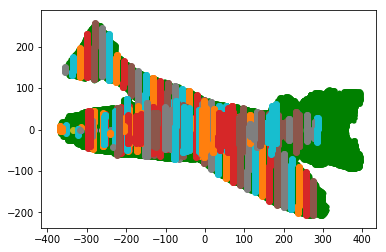

In [44]:
print("girth")
cnn_girths = girth(detection_results, cnn_lengths, 10)

In [47]:
print(cnn_girths[0][0])

12.000000000000002


In [26]:
def measure(results_list, manual=False):
    length_list = []

    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
    # TODO why is this loaded???
    
    # Measuring process is repeated for each item in the array results_list
    for mask_list in results_list:
        if not manual:
            mask = mask_list[0][0]["masks"]
        else:
            mask = mask_list
            
        body = find_correct_mask(mask)  # Ignore pectoral masks
        xy_array = pca(body)
        x_transformed = xy_array[0]
        y_transformed = xy_array[1]
        
        # Reassign max/min X values in case image was flipped during PCA
        maxX = np.max(x_transformed) # Right-most point
        minX = np.min(x_transformed) # Left-most point

        # Get corresonding Y values for maxX and minX

        maxX_index = np.where(x_transformed == maxX)  # index of right-most point
        rightY = float((y_transformed[maxX_index]))   # corresponding Y value

        minX_index = np.where(x_transformed == minX)  # index of left-most point
        leftY = float((y_transformed[minX_index]))    # corresponding Y value
            
        # Draw a straight line across the mask

        # TODO come up with a better solution here
        # Filter out points close to the midline of the mask (on the Y axis)
        # TODO arbitrary lambda, might need to change later
        lowEnough = list(filter(lambda y: y < (leftY + 0.5), y_transformed)) #above midline
        yValues = list(filter(lambda y: y > (leftY - 0.5), lowEnough)) #below midline
        yValues.sort()

        # Get corresponding X values to draw the line

        # List of appropriate indices
        indices = []
        for point in yValues:
            index = int(np.where(y_transformed == point)[0])
            indices.append(index)
    
        xValues = [] # Corresponding X values
        for index in indices:
            xValues.append(x_transformed[index]) 

        xValues.sort()

        # Use distance formula to measure the length from the midline
        length = math.sqrt((xValues[-1] - xValues[0])**2 + (yValues[-1] - yValues[0])**2)
        
       
        if np.array_equal(results_list, detection_results): # Append to CNN object for auto-generated masks
            item.append(length)
        else:
            manual_length_list.append(length) # Create and return a new list of lengths for manual masks
        
    
    if np.array_equal(results_list, detection_results): # Append to CNN object
        return
    else:
        return manual_length_list
    

In [80]:
additional_results = run_cnn(weights_path='/home/clifgray/Code/cetacean_photogram/logs/whale20180815T0121/mask_rcnn_whale_0064.h5')
append_measurements(additional_results) # CNN appends length 
additional_df = create_df(additional_results, '../photogram_data/whale_measurements.csv')
convert_measurements(additional_df)

Loading weights  /home/clifgray/Code/cetacean_photogram/logs/whale20180815T0121/mask_rcnn_whale_0064.h5
Weights loaded.


True

In [87]:
for index, row in additional_df.iterrows():
    diff = row['detected_len'] - row['Total Length (m)']
    if abs(diff) > 1.2:
        print(row["Image"])
        print(diff)
       # print(row['Total Length (m)'])
        #print(row["gt_len"])

DSC00429.JPG
-4.427345241996004
DSC09175.JPG
-3.8104367638908005
DSC09258.JPG
-8.055659734564074
DSC05019.JPG
-1.6395333021501273
DSC01963.JPG
-9.290056754513504
DSC01317.JPG
-2.805915819623502
DSC00660.JPG
-1.9683515833236722


In [86]:
for index, row in new_merged_df.iterrows():
    diff = row['detected_len'] - row['Total Length (m)']
    if abs(diff) > 1.2:
        print(row["Image"])
        print(diff)
        #print(row['Total Length (m)'])
        #print(row["gt_len"])

DSC03331.JPG
-1.2156031819014679
DSC00429.JPG
-5.1100191368553105
DSC09175.JPG
-3.8104491066657022
DSC09258.JPG
-8.267987815908732
DSC05019.JPG
-1.5532129328290907
DSC01317.JPG
-1.7550674691149268
DSC00660.JPG
-1.782827367735477


In [95]:
(additional_df['detected_len'] - additional_df['gt_len']).mean()

-0.21696077571351077

In [94]:
(additional_df['detected_len'] - additional_df['Total Length (m)']).mean()

-0.8324049031323458

In [ ]:
def show_example(whale_list, index):
    
    image_id = index
    
    image, image_meta, class_ids, bbox, mask = modellib.load_image_gt(
        dataset, config, image_id, use_mini_mask=False)
    log("molded_image", image)
    log("mask", mask)
    print("mask.shape", mask.shape)
    
    item = whale_list[index]
    if np.array_equal(whale_list, detection_results):
        mask = item[0][0]["masks"]
    else:
        mask = item 

    visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names, show_bbox=False)
    

    length_list = []

    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
    
    body = find_correct_mask(mask)
    xy_array = pca(body, True)
    x_transformed = xy_array[0]
    y_transformed = xy_array[1]
        #Reassign max/min X values in case image was flipped

    maxX = np.max(x_transformed) #rightX
    minX = np.min(x_transformed) #leftX
    
#Get corresonding Y values for leftX and rightX

    maxX_index = np.where(x_transformed == maxX) #index of right-most point
    rightY = float((y_transformed[maxX_index])) #corresponding Y value


    minX_index = np.where(x_transformed == minX) #index of left-most point
    leftY = float((y_transformed[minX_index])) #corresponding Y value
        
        
#Get points from leftX and rightX until it runs off the mask

#Filter out points above straight line 
#Arbitrary lambda, might need to change later
    lowEnough = list(filter(lambda y: y < (leftY + 0.5), y_transformed))
    yValues = list(filter(lambda y: y > (leftY - 0.5), lowEnough)) 
    yValues.sort()

#Get corresponding X values
#List of appropriate indices
    indices = []
    for point in yValues:
        index = int(np.where(y_transformed == point)[0])
        indices.append(index)
    
    xValues = [] #Corresponding X values
    for index in indices:
        xValues.append(x_transformed[index]) 

    xValues.sort()

    length = math.sqrt((xValues[-1] - xValues[0])**2 + (yValues[-1] - yValues[0])**2)
    length_list.append(length)
        
    if np.array_equal(whale_list, detection_results): #CNN Masks, length is appended to object
        item.append(length)

    #plt.plot(x_transformed, y_transformed, alpha = 0.5)
    plt.plot(x_transformed, y_transformed, 'g.', zorder=0)
    
    # set axis limits
    plt.xlim([minX - 100, maxX + 100])
    plt.ylim([leftY - 200, rightY + 200])
    
    #Plot the first and last points from the list, use this for length
    
    #plt.scatter(xValues[0], yValues[0], zorder=10)
    #plt.scatter(xValues[-1], yValues[-1], zorder=10)
    plt.scatter(xValues, yValues, zorder=10)
    plt.show()
    
    
show_example(mask_array, 3)

In [114]:
def measure(body_mask, visualize=False):
    xy_array = pca(body_mask, visualize=visualize)
    x_transformed = xy_array[0]
    y_transformed = xy_array[1]

    # Reassign max/min X values in case image was flipped during PCA
    maxX = np.max(x_transformed) # Right-most point
    minX = np.min(x_transformed) # Left-most point

    # Get corresponding Y values for maxX and minX
    maxX_index = np.where(x_transformed == maxX)  # index of right-most point
    rightY = float((y_transformed[maxX_index]))   # corresponding Y value

    minX_index = np.where(x_transformed == minX)  # index of left-most point
    leftY = float((y_transformed[minX_index]))    # corresponding Y value

    # TODO come up with a better solution here

    # Draw a straight line across the mask

    # Filter out points close to the midline of the mask (on the Y axis)
    # TODO arbitrary lambda, might need to change later
    lowEnough = list(filter(lambda y: y < (leftY + 0.5), y_transformed)) #above midline
    yValues = list(filter(lambda y: y > (leftY - 0.5), lowEnough)) #below midline
    yValues.sort()

    # Get corresponding X values to draw the line

    # List of appropriate indices
    indices = []
    for point in yValues:
        index = int(np.where(y_transformed == point)[0])
        indices.append(index)

    xValues = [] # Corresponding X values
    for index in indices:
        xValues.append(x_transformed[index]) 

    xValues.sort()

    # Use distance formula to measure the length from the midline
    length = math.sqrt((xValues[-1] - xValues[0])**2 + (yValues[-1] - yValues[0])**2)
    
    if visualize:
    
        #plt.plot(x_transformed, y_transformed, alpha = 0.5)
        plt.plot(x_transformed, y_transformed, 'g.', zorder=0)

        # set axis limits
        plt.xlim([minX - 100, maxX + 100])
        plt.ylim([leftY - 200, rightY + 200])

        #Plot the first and last points from the list, use this for length

        #plt.scatter(xValues[0], yValues[0], zorder=10)
        #plt.scatter(xValues[-1], yValues[-1], zorder=10)
        plt.scatter(xValues, yValues, zorder=10)
        plt.show()
    
    return(length)
        

In [133]:
additional_results[0][1]

'DSC03331.JPG'

0
52.16229242337221


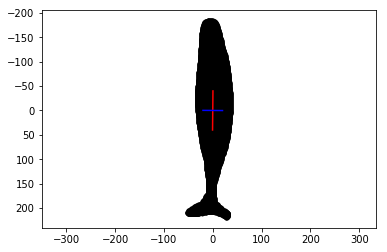

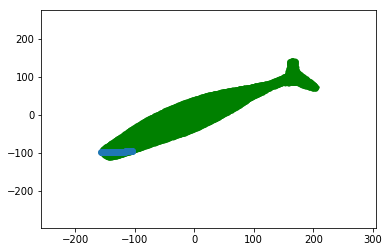

In [136]:
# TODO need to make sure that it is displaying the largest mask
for img in additional_results:
    if img[1] == "DSC09258.JPG": 
        
        try:
            longest_index = -1
            longest_length = 0
            for index, detection in enumerate(img[4]): # this is the detected mask class and can have multiple
                print(index)
                # take the longest mask
                if detection[1] > longest_length:
                    longest_index = index
                    longest_length = detection[1]
                    print(longest_length)

            measure(img[0][0]['masks'][:,:,longest_index], visualize=True)

        except IndexError: # in case a detection was not made
            pass
        except TypeError: # also in case a detection was not made
            pass
    


0
295.20642126209594
1
2


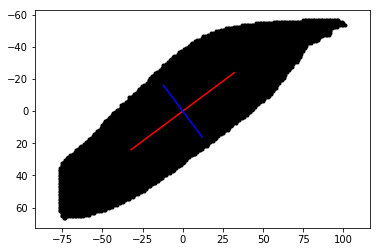

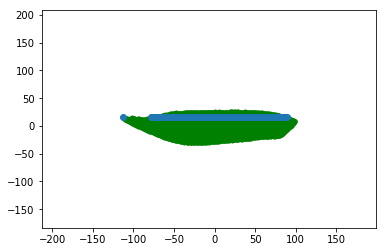

In [142]:
# TODO need to make sure that it is displaying the largest mask
for img in additional_results:
    if img[1] == "DSC01963.JPG": 
        
        try:
            longest_index = -1
            longest_length = 0
            for index, detection in enumerate(img[4]): # this is the detected mask class and can have multiple
                print(index)
                # take the longest mask
                if detection[1] > longest_length:
                    longest_index = index
                    longest_length = detection[1]
                    print(longest_length)

            measure(img[0][0]['masks'][:,:,2], visualize=True)

        except IndexError: # in case a detection was not made
            pass
        except TypeError: # also in case a detection was not made
            pass
    


0
55.76552518808449


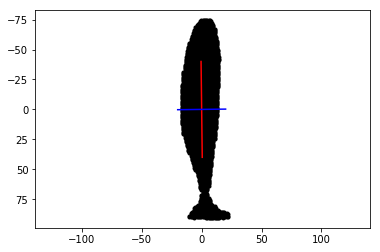

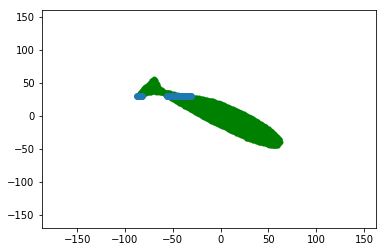

In [144]:
# TODO need to make sure that it is displaying the largest mask
for img in additional_results:
    if img[1] == "DSC00429.JPG": 
        
        try:
            longest_index = -1
            longest_length = 0
            for index, detection in enumerate(img[4]): # this is the detected mask class and can have multiple
                print(index)
                # take the longest mask
                if detection[1] > longest_length:
                    longest_index = index
                    longest_length = detection[1]
                    print(longest_length)

            measure(img[0][0]['masks'][:,:,0], visualize=True)

        except IndexError: # in case a detection was not made
            pass
        except TypeError: # also in case a detection was not made
            pass
    


0
189.9944298932187
1
218.08481854999272


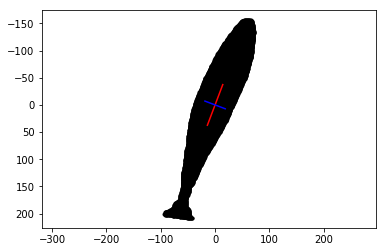

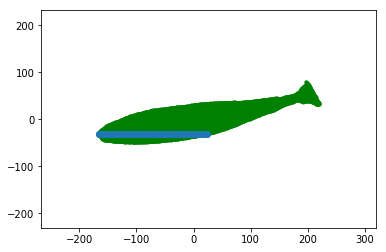

In [145]:

# TODO need to make sure that it is displaying the largest mask
for img in additional_results:
    if img[1] == "DSC09175.JPG": 
        
        try:
            longest_index = -1
            longest_length = 0
            for index, detection in enumerate(img[4]): # this is the detected mask class and can have multiple
                print(index)
                # take the longest mask
                if detection[1] > longest_length:
                    longest_index = index
                    longest_length = detection[1]
                    print(longest_length)

            measure(img[0][0]['masks'][:,:,0], visualize=True)

        except IndexError: # in case a detection was not made
            pass
        except TypeError: # also in case a detection was not made
            pass
    